In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import torch
import string
import nltk
import pandas as pd
import tweepy
import json
import csv
import numpy as np
import plotly.express as px

## Obtaining tweets

In [0]:
class Covid19Listener(tweepy.StreamListener):

    def __init__(self, f):
        super().__init__()
        self.i = 0
        self.file = open(f, 'w', newline='')
        self.writer = csv.writer(self.file, delimiter=',')

    def on_status(self, status):
        lan = status._json['lang']
        if hasattr(status, 'retweeted_status'):
            try:
                tweet = status.retweeted_status.extended_tweet["full_text"]
            except:
                tweet = status.retweeted_status.text
        else:
            try:
                tweet = status.extended_tweet["full_text"]
            except AttributeError:
                tweet = status.text
        
        if lan == 'en':
            self.writer.writerow([self.i, tweet])
            self.i += 1
            print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
            print('tweet # {}'.format(self.i))
            print('-----------')
            print(tweet)


        def on_error(self, status):
            print(status)

In [0]:
with open('apis.json') as js:
    keys = json.load(js)

access_token = keys['access token']
access_token_secret = keys['access secret']
consumer_key = keys['consumer key']
consumer_secret = keys['consumer secret']

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

In [0]:
#spy = Covid19Listener('data/raw_tweets1.csv')
#stream = tweepy.Stream(auth, spy, tweet_mode='extended')
#stream.filter(track=['corona', 'covid19', 'coronavirus', 'corona virus', 'lockdown'])

## Preprocessing tweets

In [0]:
Documents = {}
with open('raw_tweets1.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        key, txt = row[0], row[1]
        Documents[key] = txt

In [0]:
#import pickle 
#with open('data/tweets.pkl', 'wb') as f:
#    pickle.dump(Documents, f)

In [0]:
import pickle
documents = {}
with open('tweets.pkl', 'rb') as f:
    documents = pickle.load(f)

In [0]:
del documents['1']  # empty
del documents['2']  # empty

TOPICS Extraction

I have shared a very basic tutorial on how to extract topics from text using non-negative matrix factorization;
We don't have to implement an exact factorization, an approximation using gradient descent is more than enough.

Check out this :3
(https://yassine-mhedhbi.github.io/2020/02/28/nmf.html)

In [26]:
doc = []
for k in documents:
  doc.append(documents[k])
doc

['Instead of listening to "wealthy outside voices", the White House should be listening to medical experts https://t.co/JWxkpXv1ql',
 'As at today the total number of confirmed #COVID19 cases is 2028 and the total number of deaths is 25 (Additional death from yesterday: A 61 year old male)',
 'It has taken this long for Priti Patel to front the #DailyBriefing because she had to undergo intensive training in how not to smirk while announcing death tolls.\n#pritipatel #coronavirus https://t.co/lO7I9oFHOT',
 'I’m sorry if you feel that’s an apology but it absolutely fucking isn’t',
 'The Duke himself @stueymartin86 (AKA Scottish Hugh Jackman) \n\nhttps://t.co/K0qr5ps5oq',
 'Ref  1.W. Hsia Emerging new coronavirus infection in Wuhan, China: situation in early 2020 Case Study Case Rep, 10 (2020), pp. 8-9 View Record ScopusGoogleScholar2.S. Yasri, V. WiwanitkitEditorial: Wuhan coronavirus outbreak and imported caseAdv Trop Med Public Health Int,9(2019)',
 'Poetic justice. Endangering people’

In [0]:
# nltk.download()

In [0]:
with open('clean_tweets.pkl', 'wb') as f:
    pickle.dump(clean_tweets, f)

### Quick sentiment analysis

In [0]:
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

#### Wordcloud

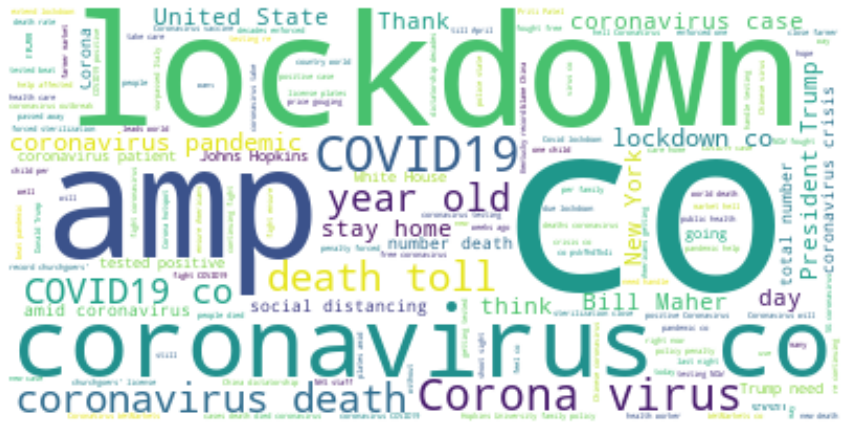

In [118]:
stop = STOPWORDS.copy()
stop.add('https')
wordcloud_spam = WordCloud(background_color="white", stopwords=stop).generate(' '.join(doc))
plt.figure(figsize = (15,15))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

we couldve removed https from the words but wtv ..

In [0]:
pd.set_option('display.max_colwidth', None)
sentiment = pd.DataFrame()
sentiment['tweet'] = clean_tweets
sentiment['Polarity'] = sentiment['tweet'].apply(lambda t: TextBlob(t).sentiment[0])

In [0]:
def get_label(t):
  if t < -0.05:
    return 'neg'
  elif t >= 0.15:
    return 'pos'
  else:
    return 'neutral'

sentiment['sentiment'] = sentiment['Polarity'].apply(get_label)

In [106]:
px.histogram(sentiment['sentiment'], x='sentiment', nbins=3, title='Twitter Sentiment analysis')

### Extracting topics

In [0]:
import logging 


logging.basicConfig(filename='logs/nmf.log', level=logging.DEBUG,
                    format='%(asctime)s:%(levelname)s:%(message)s')


def pen(A) : return (((A < 0) * A)**2).mean()
def loss(M): return (M - W@H).norm(2) + 1e6*pen(W) + 1e6*pen(H)

def NFM(M, d, a, epochs=1000):
    """M: initial matrix, d: intermediate shape i.e. (mxn)-> (mxd)(d,n), a: learning late alpha, epochs: number of epochs"""
    M = torch.Tensor(M).cuda()
    m, n = M.shape
    
    with torch.no_grad():
      W = torch.randn((m,d), requires_grad=True, dtype=torch.float, device='cuda:0').abs_()
      H = torch.randn((d,n), requires_grad=True, dtype=torch.float, device='cuda:0').abs_()
    losses = []
    i = 0
    opt = torch.optim.Adam([W,H], lr=5e-3, betas=(0.9,0.9))
    for i in range(epochs):
        opt.zero_grad()
        l = (M - W @ H).norm(2) + 1e6* (((W < 0) * W)**2).mean() + 1e6*(((H < 0) * H)**2).mean()
        losses.append(l)
        l.backward()
        #update our parameters.
        opt.step()
        i += 1
        if i % 50 == 0:
            a = a * 0.8
            logging.info(f'{i} loss: {(M - W @ H).norm(2).mean().item()}, min value in W: {W.min()}, min value in H: {H.min()}')
    
    return W, H, losses


In [58]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors = vectorizer_tfidf.fit_transform(clean_tweets[:20000]).todense() 
vectors.shape 

(20000, 27746)

In [0]:
table = str.maketrans('', '', string.punctuation)
stop_words = set(stopwords.words('english'))


clean_tweets = []
for tweet in doc:
  tokens = word_tokenize(tweet)
  tokens = [w.translate(table) for w in tokens]
  tokens = [word for word in tokens if word.isalpha()]
  tweet = [w for w in tokens if w not in stop_words]
  if len(tweet) > 2:
    clean_tweets.append(' '.join(tweet))

In [0]:
W, H , _ = NFM(vectors, 3, 0.01)
vocab = np.array(vectorizer_tfidf.get_feature_names())

In [0]:
def show_topics(H, num_top_words):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in H])
    return [', '.join(t) for t in topic_words]

Topics = show_topics(H.cpu().detach().numpy(), 6)

In [127]:
print('Extracting Topics:')
for i, topic in enumerate(Topics):
  print(f"{i}: {topic}")

Extracting Topics:
0: https, coronavirus, lockdown, people, trump, testing
1: deaths, italy, cases, number, total, new
2: china, sterilization, farmer, penalty, wetmarkets, dictatorship
